In [813]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [814]:
df = pd.read_csv('loan.csv')

In [815]:
df.head()

,age,gender,occupation,education_level,marital_status,income,credit_score,loan_status
0,32,Male,Engineer,Bachelor's,Married,85000,720,Approved
1,45,Female,Teacher,Master's,Single,62000,680,Approved
2,28,Male,Student,High School,Single,25000,590,Denied
3,51,Female,Manager,Bachelor's,Married,105000,780,Approved
4,36,Male,Accountant,Bachelor's,Married,75000,710,Approved


# Data Cleaning

In [816]:
df.isnull().sum()

age                0
gender             0
occupation         0
education_level    0
marital_status     0
income             0
credit_score       0
loan_status        0
dtype: int64

We have no reported null values

In [817]:
df[df.duplicated()]

,age,gender,occupation,education_level,marital_status,income,credit_score,loan_status


We have no duplicates

In [818]:
df.dtypes

age                 int64
gender             object
occupation         object
education_level    object
marital_status     object
income              int64
credit_score        int64
loan_status        object
dtype: object

All columns have the appropriate data types

# Exploratory Data Analysis

In [819]:
df.describe(include='object')

,gender,occupation,education_level,marital_status,loan_status
count,61,61,61,61,61
unique,2,38,5,2,2
top,Male,Engineer,Bachelor's,Married,Approved
freq,31,5,23,37,45


Our dataset is really small, with only 61 records.<br>
Of the 61 records, we have 38 different occupations.  Predicting whether a person is elgible for loan or not using the occupation will not be as straight forward, as we have less training data.

In [820]:
df.shape

(61, 8)

In [821]:
df.describe()

,age,income,credit_score
count,61.000000,61.000000,61.000000
mean,37.081967,78983.606557,709.836066
std,8.424755,33772.025802,72.674888
min,24.000000,25000.000000,560.000000
25%,30.000000,52000.000000,650.000000
50%,36.000000,78000.000000,720.000000
75%,43.000000,98000.000000,770.000000
max,55.000000,180000.000000,830.000000


The average age in this dataset is 37.<br>
Most customers of this bank have an average income of 78 983.6<br>
And finally, the average credit score for customers is 709.8

This data will look better visually so let's make use of Python's most famous plotting library, matplotlib

age                Axes(0.125,0.11;0.227941x0.77)
income          Axes(0.398529,0.11;0.227941x0.77)
credit_score    Axes(0.672059,0.11;0.227941x0.77)
dtype: object

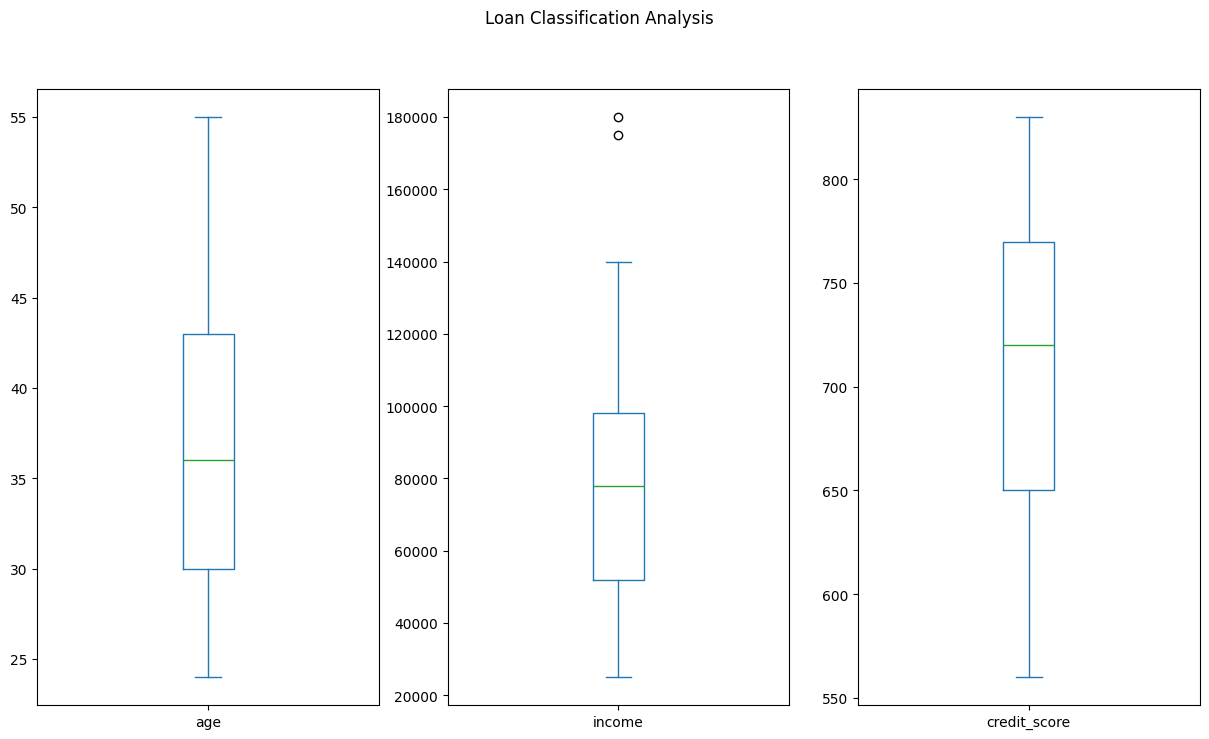

In [822]:
df.loc[:, ['age', 'income', 'credit_score']].plot(kind='box', subplots=True, figsize=(15, 8), title='Loan Classification Analysis')

Now we can get a clear picture of how our data looks like.<br>
We have customers whose income are almost close to 200000.  This might affect our prediction task as outliers influence the accuracy of the model.  We will have to deal with this later by capping the outliers.

In [823]:
df

,age,gender,occupation,education_level,marital_status,income,credit_score,loan_status
0,32,Male,Engineer,Bachelor's,Married,85000,720,Approved
1,45,Female,Teacher,Master's,Single,62000,680,Approved
2,28,Male,Student,High School,Single,25000,590,Denied
3,51,Female,Manager,Bachelor's,Married,105000,780,Approved
4,36,Male,Accountant,Bachelor's,Married,75000,710,Approved
...,...,...,...,...,...,...,...,...
56,39,Male,Architect,Master's,Married,100000,770,Approved
57,25,Female,Receptionist,High School,Single,32000,570,Denied
58,43,Male,Banker,Bachelor's,Married,95000,760,Approved
59,30,Female,Writer,Master's,Single,55000,650,Approved


In [824]:
df.groupby('loan_status')[['income', 'credit_score','age']].mean()

,income,credit_score,age
loan_status,,,
Approved,92955.555556,745.111111,40.311111
Denied,39687.500000,610.625000,28.000000


The average age of customers whose loan application were denied ranges around 39687.5 where as for those whose loan application were approved ranges around 92955.  This shows that the likelihood of a customer's loan application being approved or denied depends on the loan status

The same applies for credit score and age, approved loan applications are dependant on higher credit score and older age

array([[<Axes: title={'center': 'income'}, xlabel='loan_status'>,
        <Axes: title={'center': 'credit_score'}, xlabel='loan_status'>],
       [<Axes: title={'center': 'age'}, xlabel='loan_status'>,
        <Axes: xlabel='loan_status'>]], dtype=object)

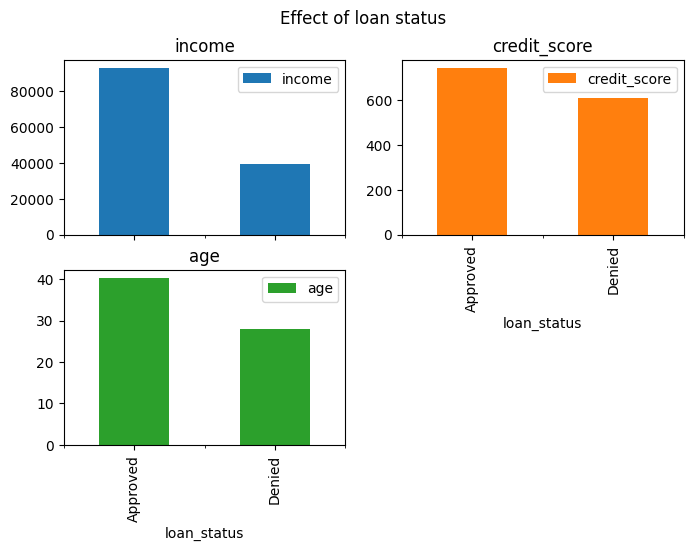

In [825]:
df.groupby('loan_status')[['income', 'credit_score','age']].mean().plot(kind='bar', subplots=True, layout=(2,2), figsize=(8,5), title='Effect of loan status')

The visualization above only confirms our assumptions of the data.  Now let's drop the occupation column, it won't contribute much to our output

In [826]:
df = df.drop('occupation', axis=1)

# Model Building

We will use ordinal encoding to convert loan_status column to numeric

In [827]:
df.loc[:, 'loan_status'] = df['loan_status'].map({"Approved": 1, "Denied": 0})

In [828]:
df['loan_status'] = df['loan_status'].astype(int)

In [829]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

Splitting the data into X_train and y_train, for training our data.  And X_test and y_test for testing our model.

In [830]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Now we want to use scikit-learn's pipeline feature to simplify our data model building workflow by concatenating multiple steps into one such as OneHotEncoding, Scaling and building the model itself

In [831]:
numerical_cols = ['age', 'income', 'credit_score']

In [832]:
categorical_cols = ['gender', 'education_level', 'marital_status']

We will use standard scaler on numeric columns and one hot encoding on categorical columns

In [833]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder()),

])

The column transformer makes it suitable to make custom preprocessing on specific columns

In [834]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols),
])

In [835]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('estimator', LogisticRegression())
])

Now we fit our data

In [836]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'income',
                                                   'credit_score']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'education_level',
                                                   'marital_status'])])),
                ('estimator', LogisticRegression())])

In [837]:
pipeline.score(X_test, y_test)

1.0

Our model has performed exceptionally well!